In [ ]:
!pip install transformers
!pip install pydicom
!pip install pylibjpeg pylibjpeg-libjpeg


In [94]:
import os
os.chdir('/content/drive/Shareddrives/EtemadiLab/Perceiver')

In [95]:
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import itertools
from zipfile import ZipFile
import io
from glob import glob
from tqdm import tqdm
import pydicom
from transformers import PerceiverForMultimodalAutoencoding


In [3]:
from PIL import Image
import torchvision

In [4]:
df = pd.read_csv('final_df.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,study,series,path,label,data,dx
0,CQ500-CT-1,CT 2.55mm,CQ500CT1 CQ500CT1/Unknown Study/CT 2.55mm/CT00...,0.0,"{'x': 253.78652000000002, 'y': 273.25843, 'wid...",Bilateral Intracranial Hemorrhages: Intraparen...
1,CQ500-CT-1,CT 2.55mm,CQ500CT1 CQ500CT1/Unknown Study/CT 2.55mm/CT00...,1.0,"{'x': 145.92135, 'y': 212.13483, 'width': 107....",Bilateral Intracranial Hemorrhages: Intraparen...
2,CQ500-CT-1,CT 2.55mm,CQ500CT1 CQ500CT1/Unknown Study/CT 2.55mm/CT00...,2.0,"{'x': 125.06742, 'y': 123.6854, 'width': 235.8...",Bilateral Intracranial Hemorrhages: Intraparen...
3,CQ500-CT-1,CT 2.55mm,CQ500CT1 CQ500CT1/Unknown Study/CT 2.55mm/CT00...,0.0,"{'x': 243.00834, 'y': 272.77306, 'width': 33.7...",Bilateral Intracranial Hemorrhages: Intraparen...
4,CQ500-CT-1,CT 2.55mm,CQ500CT1 CQ500CT1/Unknown Study/CT 2.55mm/CT00...,0.0,"{'x': 183.9383, 'y': 241.81713, 'width': 25.48...",Bilateral Intracranial Hemorrhages: Intraparen...


In [11]:
combos = [tup for tup in itertools.product(df.study.unique(), df.series.unique())]

In [16]:
combos[0]

('CQ500-CT-1', 'CT 2.55mm')

In [34]:
df[(df.series == combos[0][1]) & (df.study == combos[0][0])].sort_values('path').iloc[5].path

'CQ500CT1 CQ500CT1/Unknown Study/CT 2.55mm/CT000003.dcm'

In [5]:
class CQDS(Dataset):
  def __init__(self, df, frames=16):
    super().__init__()
    self.df = df
    self.combos = [tup for tup in itertools.product(df.study.unique(), df.series.unique())]
    self.frames = frames
    self.tfms = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), 
                                                torchvision.transforms.Grayscale(3)])
  
  def __len__(self):
    return len(self.combos)
  
  def __getitem__(self, idx):
    study, series = self.combos[idx]
    df = self.df[(self.df.study == study) & (self.df.series == series)].sort_values('path')
    imgs = []
    with ZipFile(f'{study}.zip', 'r') as zip:
      for path in df.path.iloc[:self.frames]:
        dcm = pydicom.read_file(io.BytesIO(zip.read(path)))
        imgs.append(self.tfms(Image.fromarray(np.uint8(dcm.pixel_array))))
    imgs = np.stack(imgs)
    return imgs, df.iloc[0].dx


        





In [82]:
ds = CQDS(df)

In [88]:
ds[0][1]

'Bilateral Intracranial Hemorrhages: Intraparenchymal Hemorrhage, Subarachnoid Hemorrhage with mass effect and midline shift. No fractures.'

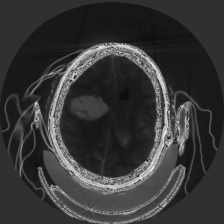

In [89]:
Image.fromarray(ds[0][0][0])

In [103]:
# create multimodal inputs
images = torch.randn((8, 16, 3, 224, 224))
audio = torch.randn((8, 30720, 1))
inputs = dict(image=images, audio=audio, label=torch.zeros((images.shape[0], 700)))

In [99]:
model = PerceiverForMultimodalAutoencoding.from_pretrained("deepmind/multimodal-perceiver")

In [104]:
# in the Perceiver IO paper, videos are auto-encoded in chunks
# each chunk subsamples different index dimensions of the image and audio modality decoder queries
nchunks = 128
image_chunk_size = np.prod((16, 224, 224)) // nchunks
audio_chunk_size = audio.shape[1] // model.config.samples_per_patch // nchunks

In [105]:
# process the first chunk
chunk_idx = 0
subsampling = {
    "image": torch.arange(image_chunk_size * chunk_idx, image_chunk_size * (chunk_idx + 1)),
    "audio": torch.arange(audio_chunk_size * chunk_idx, audio_chunk_size * (chunk_idx + 1)),
    "label": None,
}

In [ ]:
outputs = model(inputs=inputs, subsampled_output_points=subsampling)
logits = outputs.logits